In [1]:
# imports
import cv2
import numpy as np
import scipy.stats as ss
from sklearn.cluster import KMeans
import skimage
from skimage.color import rgb2gray
from skimage import img_as_float
from skimage.feature import local_binary_pattern
import imageio
import mpmath
import matplotlib.pyplot as plt
import seaborn as sns
import PIL

import os
import math

# CV Lab 4 - 1877342

In [2]:

def load_images_from_folder(folder):
    images = []
    masks = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            #print(filename)
            if filename.split("-")[0] == "image":
                images.append(img)
            else:
                masks.append(img)
    return images, masks

In [3]:
# read in images and masks
images, masks = load_images_from_folder("images")

# choose ONE image to work with for sections 4, 5, 6
image = images[0]
mask = masks[0]
mask = rgb2gray(mask)

gray_image = rgb2gray(image)
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
image = img_as_float(image)

In [4]:
def min_max_contrast_stretch(image, int_type=False, grey=False):
    stretched_img = image
    if not grey:
      if int_type == False:
          for i in range(3):
              minimum = min([min(p) for p in stretched_img[:, :, i]])
              maximum = max([max(p) for p in stretched_img[:, :, i]])
              for y in range(stretched_img.shape[0]):
                  for x in range(stretched_img.shape[1]):
                      stretched_img[y, x, i] = (stretched_img[y, x, i] - minimum) / (maximum - minimum)
      elif int_type == True:
          for i in range(3):
              minimum = min([min(p) for p in stretched_img[:, :, i]])
              maximum = max([max(p) for p in stretched_img[:, :, i]])
              for y in range(stretched_img.shape[0]):
                  for x in range(stretched_img.shape[1]):
                      stretched_img[y, x, i] = (stretched_img[y, x, i] - minimum) / (maximum - minimum) * 255

    else:
      # stretch greyscale image
      if int_type == False:
        minimum = min([min(p) for p in stretched_img])
        maximum = max([max(p) for p in stretched_img])
        for y in range(stretched_img.shape[0]):
          for x in range(stretched_img.shape[1]):
            stretched_img[y, x] = (stretched_img[y, x] - minimum) / (maximum - minimum)
      elif int_type == True:
        minimum = min([min(p) for p in stretched_img])
        maximum = max([max(p) for p in stretched_img])
        for y in range(stretched_img.shape[0]):
          for x in range(stretched_img.shape[1]):
            stretched_img[y, x] = (stretched_img[y, x] - minimum) / (maximum - minimum) * 255
                    
    return stretched_img

In [5]:
# downscale image
image = img_as_float(cv2.resize(image, (640, 480)))
gray_image = img_as_float(cv2.resize(gray_image, (640, 480)))
mask = img_as_float(cv2.resize(mask, (640, 480)))

In [6]:
image2 = images[1]
mask2 = masks[1]
mask2 = rgb2gray(mask2)
gray_image2 = rgb2gray(image2)
hsv_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2HSV)
image2 = img_as_float(image2)
# downscale 2nd image
image2 = img_as_float(cv2.resize(image2, (640, 480)))
gray_image2 = img_as_float(cv2.resize(gray_image2, (640, 480)))
mask2 = img_as_float(cv2.resize(mask2, (640, 480)))

image3 = images[2]
mask3 = masks[2]
mask3 = rgb2gray(mask3)
gray_image3 = rgb2gray(image3)
hsv_image3 = cv2.cvtColor(image3, cv2.COLOR_RGB2HSV)
image3 = img_as_float(image3)
# downscale 3rd image
image3 = img_as_float(cv2.resize(image3, (640, 480)))
gray_image3 = img_as_float(cv2.resize(gray_image3, (640, 480)))
mask3 = img_as_float(cv2.resize(mask3, (640, 480)))

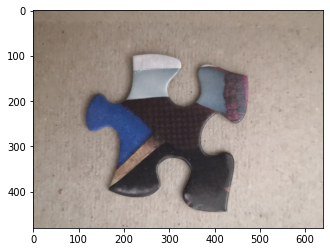

In [7]:
# display image for questions to follow
plt.imshow(image)

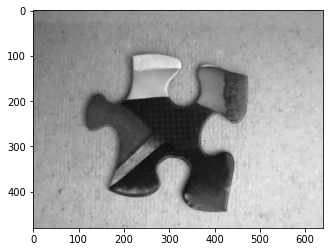

In [8]:
plt.imshow(gray_image, cmap="gray")

## Question 1: Canny Edge Detector

1.1. Implement the Canny edge detection algorithm from scratch, your function should accept a greyscale image and three tuneable named paramaters: $\sigma, low\_threshold$, and $high\_threshold$, similar in behaviour to that of the skimage canny edge detector.

- Remove any unnecessary noise by applying a Gaussian filter with $\sigma = 4$ to your greyscale image. Estimate the size of your Gaussian filter with the equation $size = 2 * radius + 1$, where $radius = floor(truncate*\sigma + 0.5)$, and $truncate = 4.0$ is the number of standard deviations away to truncate the filter.

In [9]:
def gaussian_filter(k, sigma):
    centre = k // 2
    
    f = lambda x, y: 1/(2*math.pi*math.pow(sigma, 2)) * math.exp(-(math.pow(x - centre, 2) + math.pow(y - centre, 2))/(2*math.pow(sigma, 2)))
    g = np.vectorize(f)
    K = np.fromfunction(g, (k, k))
    
    return K

- Calculate the intensity gradient of the image, comprised of orientation and magnitudes, using vertical and horizontal Sobel filters.

In [10]:
def sobel_filter(orientation=0):
  # orientation = 0 returns vertical Sobel filter
  if orientation == 0:
    return np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
  # orientation = 1 returns horizontal Sobel filter
  elif orientation == 1:
    return np.array([[1, 2, 1],
                     [0, 0, 0],
                     [-1, -2, -1]])

In [11]:
def prewitt_filter(orientation=0):
  # orientation = 0 returns vertical Prewitt filter
  if orientation == 0:
    return np.array([[1, 1, 1],
                     [0, 0, 0],
                     [-1, -1, -1]])
  # orientation = 1 returns horizontal Prewitt filter
  elif orientation == 1:
    return np.array([[1, 0, -1],
                     [1, 0, -1],
                     [1, 0, -1]])

- Apply non-maximum suppression to get rid of any unwanted pixels which may not form part of an edge, leaving you with "thin edges".

In [12]:
def non_maximum_suppression(image, orientation):
  out = image.copy()
  dim = np.shape(image)

  theta = orientation.copy()
  theta[theta < 0] += 180

  for i in range(1, dim[0] - 1):
    for j in range(1, dim[1] - 1):
      r = 255
      q = 255

      #flags = np.array([0, 0, 0, 0])
      if (0 <= theta[i][j] < 22.5) or (157.5 <= theta[i][j] <= 180):
        q = image[i][j + 1]
        r = image[i][j - 1]
      elif (22.5 <= theta[i][j] < 67.5):
        q = image[i + 1][j - 1]
        r = image[i - 1][j + 1]
      elif (67.5 <= theta[i][j] < 112.5):
        q = image[i + 1][j]
        r = image[i - 1][j]
      elif (112.5 <= theta[i][j] < 157.5):
        q = image[i - 1][j - 1]
        r = image[i + 1][j + 1]
      

      if not ((image[i][j] >= q) and (image[i][j] >= r)):
        out[i][j] = 0

  return out

- Apply double thresholding to determine potential edges. Use the weak/low threshold of 0.1 and strong/high threshold of 0.2.

In [13]:
def double_threshold(image, low=0.1, high=0.2, weak=0.1, strong=1):
  out = image.copy()
  dim = np.shape(image)

  high = image.max() * high
  low = high * low

  out[np.where(image >= high)] = strong
  out[np.where((image < high) & (image >= low))] = weak
  out[np.where(image < low)] = 0

  return out

- Track edges by Hysteresis, where weak edges are suppressed if not connected to strong edges.

In [14]:
def hysteresis(image, weak=0.1, strong=1):
  out = image.copy()
  dim = np.shape(image)

  for i in range(1, dim[0] - 1):
    for j in range(1, dim[1] - 1):
      if image[i][j] == weak:
        if (image[i - 1][j] == strong) or (image[i - 1][j + 1] == strong) or (image[i][j + 1] == strong) or (image[i + 1][j + 1] == strong) or (image[i + 1][j] == strong) or (image[i + 1][j - 1] == strong) or (image[i][j - 1] == strong) or (image[i - 1][j - 1] == strong):
          out[i][j] = strong
        else:
          out[i][j] = 0

  return out

In [15]:
def canny(image, sigma, low_threshold, high_threshold):
  # blur image
  truncate = 4.0
  radius = math.floor((truncate*sigma) + 0.5)
  k = (2 * radius) + 1
  img_gaussian = cv2.GaussianBlur(image, (k, k), sigma, borderType=cv2.BORDER_REPLICATE)

  # calculate intensity gradient using Sobel filters
  img_vert_sobel = cv2.filter2D(img_gaussian, -1, sobel_filter(0), borderType=cv2.BORDER_REFLECT)
  img_hor_sobel = cv2.filter2D(img_gaussian, -1, sobel_filter(1), borderType=cv2.BORDER_REFLECT)
  sobel = np.array([img_vert_sobel, img_hor_sobel])

  theta = np.arctan2(img_hor_sobel, img_vert_sobel) * 180 / math.pi
  mag = np.hypot(img_vert_sobel, img_hor_sobel)
  mag = mag/mag.max() * 255

  #print(max([max(p) for p in G]))
  #print(min([min(p) for p in G]))
  # apply non-maximum suppression
  img_suppressed = non_maximum_suppression(mag, theta)

  # apply double thresholding to suppressed image
  img_thresholded = double_threshold(img_suppressed, low=low_threshold, high=high_threshold)

  # track edges by hysteresis
  img_hysteresis = hysteresis(img_thresholded)

  return img_hysteresis, img_gaussian, sobel, mag, theta, img_suppressed, img_thresholded

1.2. Plot and label the results after each step in the Canny algorithm, include the blurred greyscale image, horizontal and vertical Sobel filtered images, orientation and magnitude images, non-maximum suppressed image, double thresholded images, and the final result after Hysteresis.

## Results with $\sigma = 4, low\_threshold = 0.1, high\_threshold = 0.2$:

In [16]:
# driver code
sigma = 4
low_threshold = 0.1
high_threshold = 0.2
img_canny, img_gaussian, img_sobel, img_G, img_theta, img_suppressed, img_thresholded = canny(gray_image, sigma, low_threshold=low_threshold, high_threshold=high_threshold)

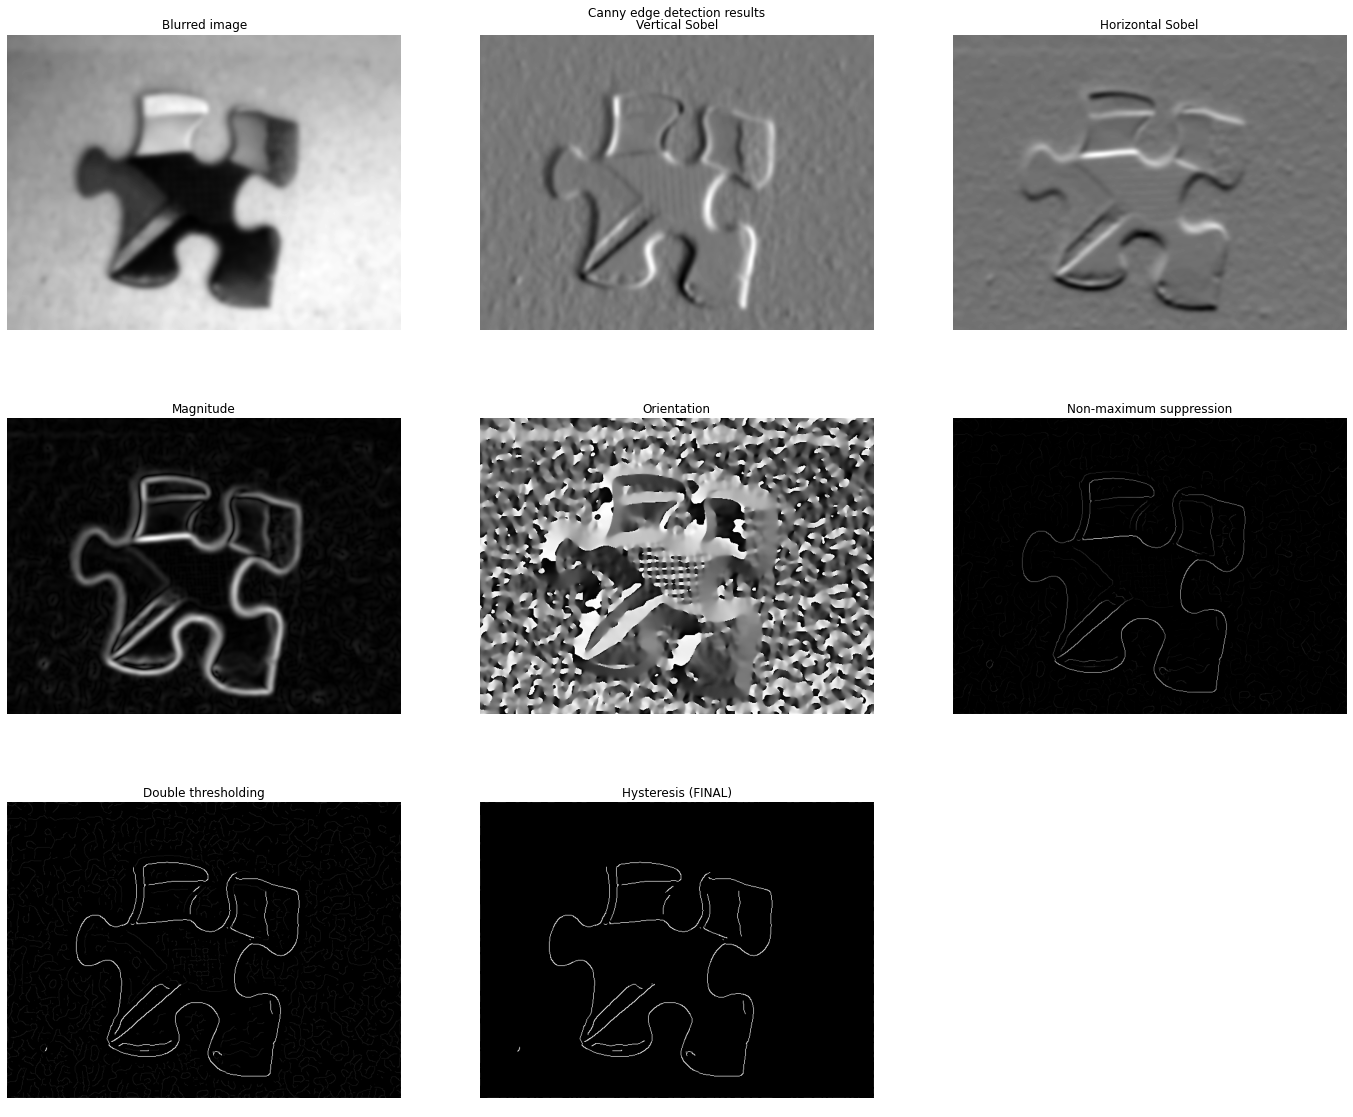

In [17]:
# plot results
fig1 = plt.figure(figsize=(24, 20))
plt.axis("off")
plt.title("Canny edge detection results")

# plot Gaussian blurred image
fig1.add_subplot(3, 3, 1)
plt.title("Blurred image")
plt.axis("off")
plt.imshow(min_max_contrast_stretch(img_gaussian, grey=True), cmap="gray")

# plot intensity gradient results
fig1.add_subplot(3, 3, 2)
plt.title("Vertical Sobel")
plt.axis("Off")
plt.imshow(min_max_contrast_stretch(img_sobel[0], grey=True), cmap="gray")

fig1.add_subplot(3, 3, 3)
plt.title("Horizontal Sobel")
plt.axis("Off")
plt.imshow(min_max_contrast_stretch(img_sobel[1], grey=True), cmap="gray")

fig1.add_subplot(3, 3, 4)
plt.title("Magnitude")
plt.axis("Off")
plt.imshow(min_max_contrast_stretch(img_G, grey=True), cmap="gray")

fig1.add_subplot(3, 3, 5)
plt.title("Orientation")
plt.axis("Off")
plt.imshow(min_max_contrast_stretch(img_theta, grey=True), cmap="gray")

# plot thresholding results
fig1.add_subplot(3, 3, 6)
plt.title("Non-maximum suppression")
plt.axis("Off")
plt.imshow(min_max_contrast_stretch(img_suppressed, grey=True), cmap="gray")

fig1.add_subplot(3, 3, 7)
plt.title("Double thresholding")
plt.axis("Off")
plt.imshow(min_max_contrast_stretch(img_thresholded, grey=True), cmap="gray")

# plot final result after hysteresis
fig1.add_subplot(3, 3, 8)
plt.title("Hysteresis (FINAL)")
plt.axis("Off")
plt.imshow(min_max_contrast_stretch(img_canny, grey=True), cmap="gray")

## Our implementation versus skimage canny function (`skimage.feature.canny`)

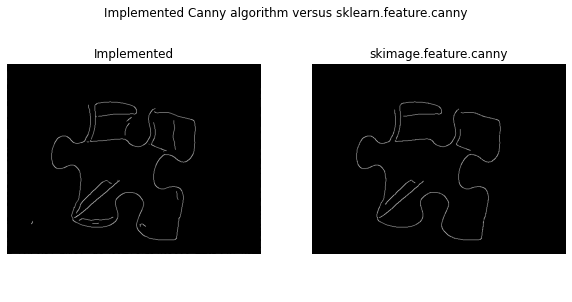

In [18]:
fig2 = plt.figure(figsize=(10,5))
plt.axis("off")
plt.title("Implemented Canny algorithm versus sklearn.feature.canny")
fig2.add_subplot(1, 2, 1)
plt.axis("Off")
plt.title("Implemented")
plt.imshow(min_max_contrast_stretch(img_canny, grey=True), cmap="gray")
fig2.add_subplot(1, 2, 2)
plt.axis("Off")
plt.title("skimage.feature.canny")
plt.imshow(skimage.feature.canny(gray_image, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold), cmap="gray")

1.4. Give reasons for the effect on the output after increasing or decreasing each parameter, including $low\_threshold, high\_threshold$ and $\sigma$. Plot your different parameter transversals used to come to your conclusions. You may use the `skimage.feature.canny` function for this question.

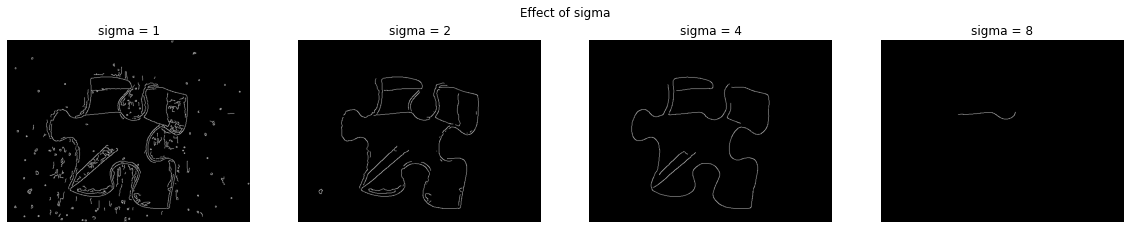

In [19]:
# defaults
sigma = 4
low_threshold = 0.1
high_threshold = 0.2

# effects of sigma
sigmas = [1, 2, 4, 8]
fig3 = plt.figure(figsize=(20,4))
plt.axis("Off")
plt.title("Effect of sigma")
idx = 1
for sigma in sigmas:
  fig3.add_subplot(1, 4, idx)
  idx += 1
  plt.axis("Off")
  plt.title("sigma = %d" % sigma)
  plt.imshow(skimage.feature.canny(gray_image, sigma, low_threshold, high_threshold), cmap="gray")

Here we can clearly see that lower values of $\sigma$ result in noisier data which causes the algorithm to return unnecessary/spurious edges. Higher values of $\sigma$, however, can over-blur the image to the point that the algorithm no longer recognises all the edges we need, and will only return edges where there are the most extreme edges in the image.

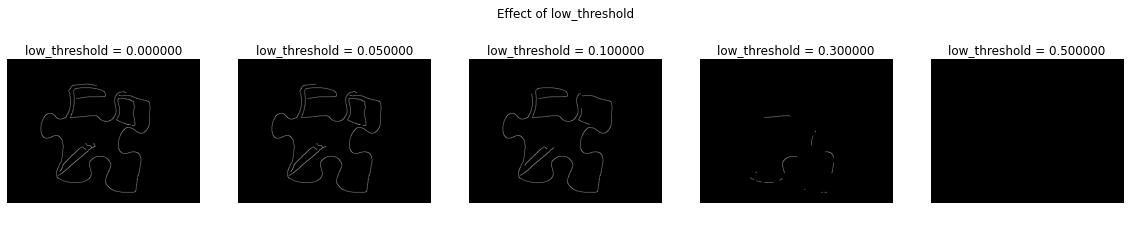

In [20]:
# defaults
sigma = 4
low_threshold = 0.1
high_threshold = 0.2

# effects of low_threshold
low_thresholds = [0, 0.05, 0.1, 0.3, 0.5]
fig4 = plt.figure(figsize=(20,4))
plt.axis("Off")
plt.title("Effect of low_threshold")
idx = 1
for low_threshold in low_thresholds:
  fig4.add_subplot(1, 5, idx)
  idx += 1
  plt.axis("Off")
  plt.title("low_threshold = %f" % low_threshold)
  plt.imshow(skimage.feature.canny(gray_image, sigma, low_threshold, high_threshold), cmap="gray")

Increasing low_threshold results in an increase in the confidence our algorithm needs to have about an edge in order to keep it. When it is too low, we end up keeping unnecessary edges, and when it is too high, we may end up dropping relevant edges.

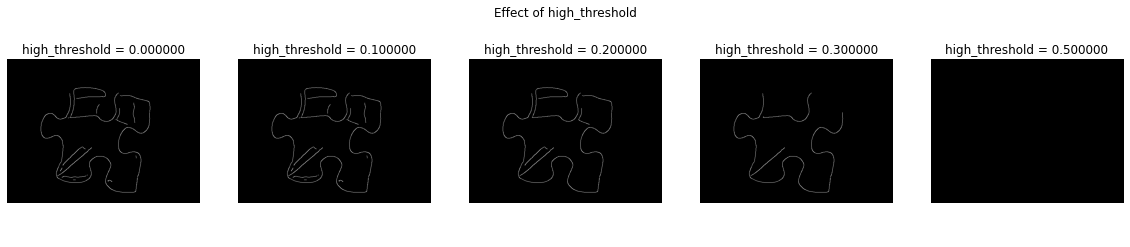

In [21]:
# defaults
sigma = 4
low_threshold = 0.1
high_threshold = 0.2

# effects of high_threshold
high_thresholds = [0, 0.1, 0.2, 0.3, 0.5]
fig5 = plt.figure(figsize=(20,4))
plt.axis("Off")
plt.title("Effect of high_threshold")
idx = 1
for high_threshold in high_thresholds:
  fig5.add_subplot(1, 5, idx)
  idx += 1
  plt.axis("Off")
  plt.title("high_threshold = %f" % high_threshold)
  plt.imshow(skimage.feature.canny(gray_image, sigma, low_threshold, high_threshold), cmap="gray")

Increasing high_threshold increases the confidence needed to keep a particular edge, and can produce cleaner results, but having too high of a high_threshold value can result in our algorithm throwing out actually relevant edges, as is the case with too high of a low_threshold value.

1.5. Adjust the parameters of your implementation to try and obtain the best or cleanest result. Plot this result with your chosen parameters. Again you may use the `skimage.feature.canny` function.

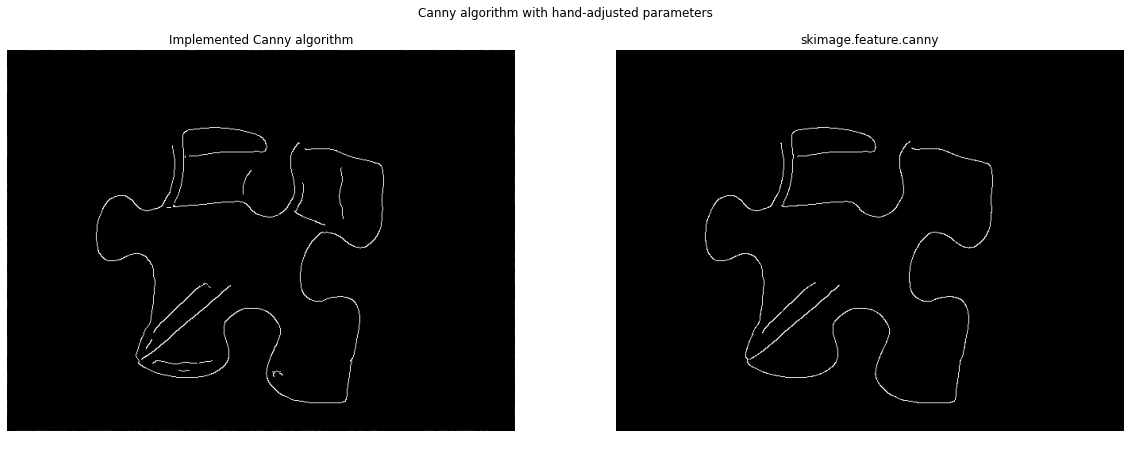

In [22]:
# parameters
# mostly wanted to achieve the most complete outline of the puzzle piece with as few unnecessary edges as possible.
sigma = 3.7
low_threshold = 0.1
high_threshold = 0.25

# our implementation
img_canny, img_gaussian, img_sobel, img_G, img_theta, img_suppressed, img_thresholded = canny(gray_image, sigma, low_threshold=low_threshold, high_threshold=high_threshold)

fig6 = plt.figure(figsize=(20,8))
plt.axis("Off")
plt.title("Canny algorithm with hand-adjusted parameters")
fig6.add_subplot(1, 2, 1)
plt.axis("Off")
plt.title("Implemented Canny algorithm")
plt.imshow(min_max_contrast_stretch(img_canny, grey=True), cmap="gray")
fig6.add_subplot(1, 2, 2)
plt.axis("Off")
plt.title("skimage.feature.canny")
plt.imshow(skimage.feature.canny(gray_image, sigma, low_threshold, high_threshold), cmap="gray")

## Question 2: Harris Corner Detector

2.1. Your task is to implement the Harris Corner Detector, your function signature should accept a greyscale image with three additional tuneable named parameters: $\sigma, \kappa$ and $\tau$, where $\sigma$ is the standard deviation of the Gaussian filter representing the weight matrix, $\kappa$ is the sensitivity factor that separates corners from edges and $\tau$ is the normalised response threshold.

- Compute your vertical and horizontal image derivatives from your greyscale image using the appropriately oriented Sobel filters and zero padding.


- Use these derivatives to compute your image structure tensors ($\textbf{S}_{ij}$ in your textbook), weighted according to the Gaussian with default $\sigma = 1$. Again use zero padding.

In [23]:
def structure_tensors(img_x, img_y, sigma=1):
  truncate = 4.0
  radius = math.floor((truncate*sigma) + 0.5)
  k = (2 * radius) + 1
  
  img_xx = cv2.GaussianBlur(img_x**2, (k, k), sigma, borderType=cv2.BORDER_CONSTANT)
  img_yy = cv2.GaussianBlur(img_y**2, (k, k), sigma, borderType=cv2.BORDER_CONSTANT)
  img_xy = cv2.GaussianBlur(img_y*img_x, (k, k), sigma, borderType=cv2.BORDER_CONSTANT)

  return img_xx, img_yy, img_xy 

- Calculate the responses ($c_{ij}$) from the structure tensors, with the default value for $\kappa = 0.05$.

In [24]:
def structure_tensor_responses(img_xx, img_yy, img_xy, kappa=0.05):
  det = (img_xx * img_yy) - img_xy**2
  trace = img_xx + img_yy
  return det - (kappa * trace**2)

- Remove spurious corners from the responses by only keeping local maxima, do this by analysing the 8 neighbouring values of the centre value in a 3x3 sliding window and keeping the centre if anf only if it is greater than its neighbours.

In [25]:
def remove_spurious_corners(image):
  out = image.copy()
  dim = np.shape(image)

  img_padded = cv2.copyMakeBorder(image, 1, 1, 1, 1, borderType=cv2.BORDER_CONSTANT, value=0)
  for i in range(1, dim[0] - 1):
    for j in range(1, dim[1] - 1):
      neighbours = np.array([img_padded[i - 1][j], 
                             img_padded[i - 1][j + 1], 
                             img_padded[i][j + 1], 
                             img_padded[i + 1][j + 1], 
                             img_padded[i + 1][j], 
                             img_padded[i + 1][j - 1], 
                             img_padded[i][j - 1], 
                             img_padded[i - 1][j - 1]])
      maximum = max(neighbours)

      if img_padded[i][j] > maximum:
        out[i][j] = img_padded[i][j]
      else:
        out[i][j] = maximum

  return out

- Use the default threshold ratio $\tau = 0.05$ to return the points where $\frac{responses}{max(responses)} > \tau$.

In [26]:
def harris(image, sigma, kappa, tau):
  dim = np.shape(image)

  # Gaussian blur
  truncate = 4.0
  radius = math.floor((truncate*sigma) + 0.5)
  k = (2 * radius) + 1

  # vertical and horizontal image derivatives using Sobel filters
  img_vert_sobel = cv2.filter2D(image, -1, sobel_filter(0), borderType=cv2.BORDER_REFLECT)
  img_hor_sobel = cv2.filter2D(image, -1, sobel_filter(1), borderType=cv2.BORDER_REFLECT)
  sobel = np.array([img_vert_sobel, img_hor_sobel]) 

  # compute image tensors with sigma = 1 and zero padding
  img_xx, img_yy, img_xy = structure_tensors(sobel[0], sobel[1], sigma)
  img_structure_tensors = np.array([img_xx, img_yy, img_xy])

  # calculate responses with kappa = 0.05
  img_tensor_res = structure_tensor_responses(img_xx, img_yy, img_xy, kappa)

  # remove spurious corners using 8 neighbours in 3x3 sliding window
  img_no_spurious = remove_spurious_corners(img_tensor_res)

  # use default threshold, tau = 0.05, to return thresholded image
  maximum = max([max(p) for p in img_no_spurious])
  points = []
  for i in range(dim[0] - 1):
    for j in range(dim[1] - 1):
      if img_no_spurious[i][j]/maximum > tau:
        points.append([i, j])

  return points, sobel, img_tensor_res, img_no_spurious

2.2. Apply your Harris corner detector to the mask image with default arguments and plot the detected corners by drawing circles around them.

In [27]:
def circle_points(image, points):
  out = image.copy()
  for p in points:
    cv2.circle(out, (p[1], p[0]), radius=10, color=(255,0,0), thickness=1)
  return out

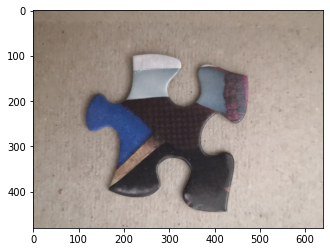

In [28]:
plt.imshow(image)

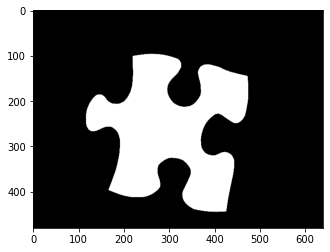

In [29]:
plt.imshow(mask2, cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


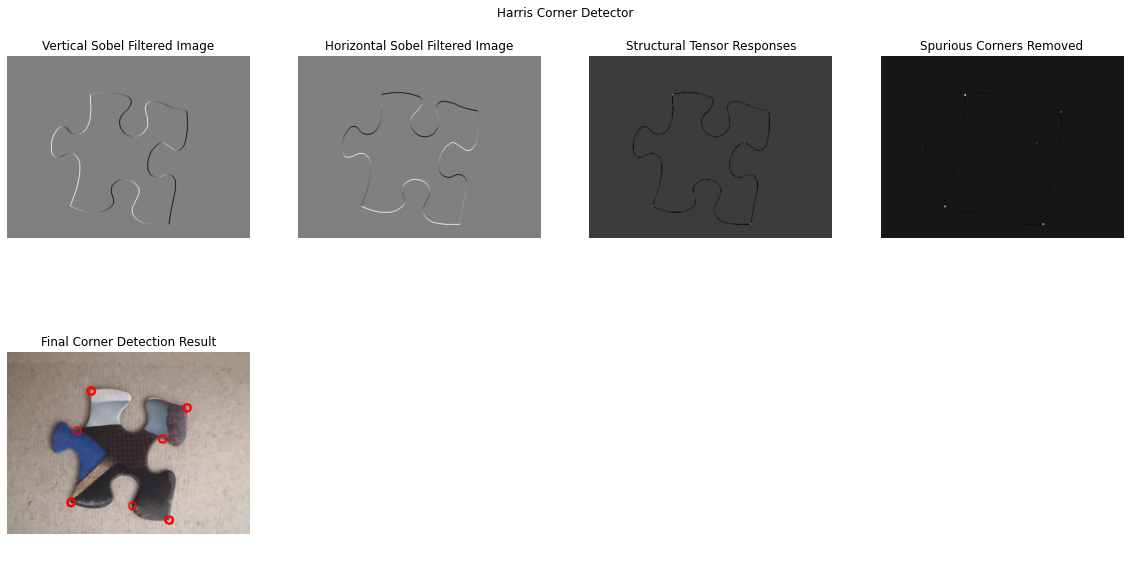

In [30]:
# driver code
sigma = 1
kappa = 0.05
tau = 0.05
points, sobel, img_tensor_res, img_no_spurious = harris(mask2, sigma, kappa, tau)

# plot results
fig7 = plt.figure(figsize=(20, 10))
plt.axis("Off")
plt.title("Harris Corner Detector")

fig7.add_subplot(2, 4, 1)
plt.axis("Off")
plt.title("Vertical Sobel Filtered Image")
plt.imshow(sobel[0], cmap="gray")

fig7.add_subplot(2, 4, 2)
plt.axis("Off")
plt.title("Horizontal Sobel Filtered Image")
plt.imshow(sobel[1], cmap="gray")

fig7.add_subplot(2, 4, 3)
plt.axis("Off")
plt.title("Structural Tensor Responses")
plt.imshow(min_max_contrast_stretch(img_tensor_res, grey=True), cmap="gray")

fig7.add_subplot(2, 4, 4)
plt.axis("Off")
plt.title("Spurious Corners Removed")
plt.imshow(min_max_contrast_stretch(img_no_spurious, grey=True), cmap="gray")

fig7.add_subplot(2, 4, 5)
plt.axis("Off")
plt.title("Final Corner Detection Result")
plt.imshow(circle_points(image, points))

2.3. Test different values of $\kappa \in \{0.025, 0.05, 0.1, 0.2\}$, $\sigma \ in \{1, 2, 4, 8\}$ and $\tau \in \{0.01, 0.05, 0.1, 0.2\}$ with your implementation of the Harris corner detector. You do not need to run through all permutations of parameters, rather plot a traversal for each parameter and keep the remainder as the defaults. Perform these tests of the greyscale version of the original image, not your mask. Draw the points on your images as in the previous question.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


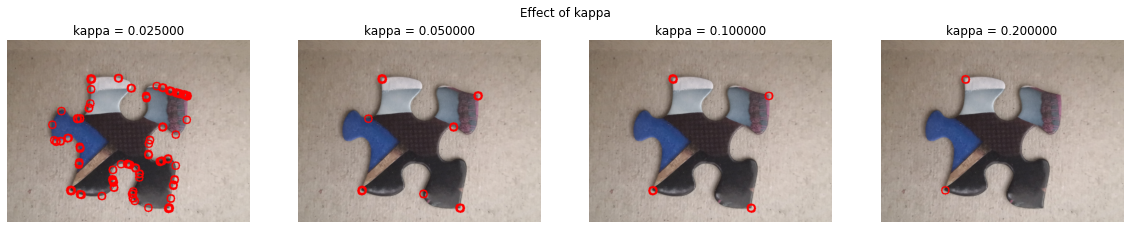

In [31]:
# defaults
sigma = 1
kappa = 0.05
tau = 0.05

# effects of kappa
kappas = [0.025, 0.05, 0.1, 0.2]
fig8 = plt.figure(figsize=(20,4))
plt.axis("Off")
plt.title("Effect of kappa")
idx = 1
for kappa in kappas:
  points, sobel, img_tensor_res, img_no_spurious = harris(mask2, sigma, kappa, tau)

  fig8.add_subplot(1, 4, idx)
  idx += 1
  plt.axis("Off")
  plt.title("kappa = %f" % kappa)
  plt.imshow(circle_points(image, points))

We see that increasing kappa reduces the number of corners that the detector returns. Increasing kappa too much results in true corners being dropped from the results.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


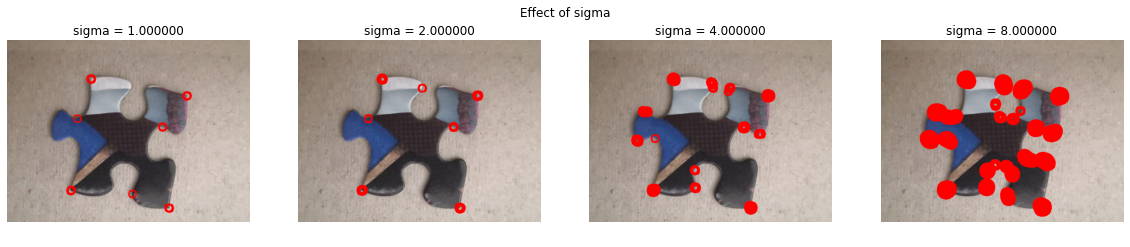

In [32]:
# defaults
sigma = 1
kappa = 0.05
tau = 0.05

# effects of sigma
sigmas = [1, 2, 4, 8]
fig9 = plt.figure(figsize=(20,4))
plt.axis("Off")
plt.title("Effect of sigma")
idx = 1
for sigma in sigmas:
  points, sobel, img_tensor_res, img_no_spurious = harris(mask2, sigma, kappa, tau)

  fig9.add_subplot(1, 4, idx)
  idx += 1
  plt.axis("Off")
  plt.title("sigma = %f" % sigma)
  plt.imshow(circle_points(image, points))

Increasing sigma appears to increase the number of points classified as corners, as well as increase the number of closely clustered points positively classified.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


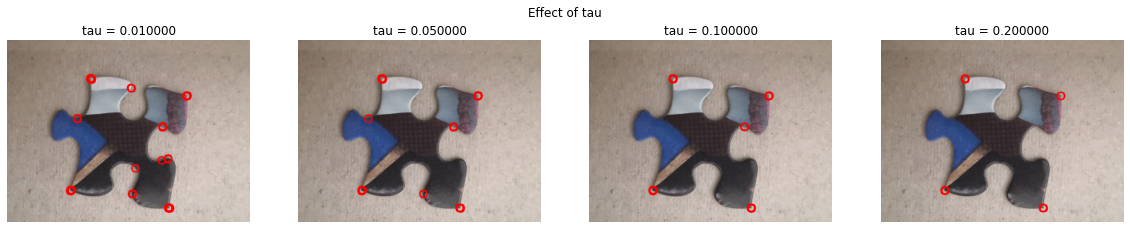

In [33]:
# defaults
sigma = 1
kappa = 0.05
tau = 0.05

# effects of tau
taus = [0.01, 0.05, 0.1, 0.2]
fig10 = plt.figure(figsize=(20,4))
plt.axis("Off")
plt.title("Effect of tau")
idx = 1
for tau in taus:
  points, sobel, img_tensor_res, img_no_spurious = harris(mask2, sigma, kappa, tau)

  fig10.add_subplot(1, 4, idx)
  idx += 1
  plt.axis("Off")
  plt.title("tau = %f" % tau)
  plt.imshow(circle_points(image, points))

Tau appears also to have an effect on the number of positively classified points and their clustering.

2.4. How could you further reduce the number of points that are closely clustered together?

We could possibly cluster the points using k-means, where k is the number of corners we are looking for, keeping the centroids as the classified corners.